# Import main libraries

In [52]:
# Basics
import pandas as pd
import numpy as np

# DataViz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading
import xgboost as xgb

# Info on dataset

| Variable |                 Definition                 |                       Key                      |
|:--------:|:------------------------------------------:|:----------------------------------------------:|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

# Import data from CSV

In [7]:
# Read data from CSV files
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
gender_data = pd.read_csv('data/gender_submission.csv')

print(f"The train dataset contains {train_data.shape[0]} lines and {train_data.shape[1]} columns.")
print(f"The test dataset contains {test_data.shape[0]} lines and {test_data.shape[1]} columns.")
print(f"The gender dataset contains {gender_data.shape[0]} lines and {gender_data.shape[1]} columns.")

print("\nHere are the first 10 lines of the train dataset.")

train_data.head(10)

The train dataset contains 891 lines and 12 columns.
The test dataset contains 418 lines and 11 columns.
The gender dataset contains 418 lines and 2 columns.

Here are the first 10 lines of the train dataset.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Handling duplicates and NaN values

In [8]:
print(f'There are {train_data.duplicated().sum()} duplicates in the train dataset')
print(f'There are {test_data.duplicated().sum()} duplicates in the test dataset')

There are 0 duplicates in the train dataset
There are 0 duplicates in the test dataset


In [9]:
print("Missing values on the train dataset:")
display(train_data.isna().sum())

print("Missing values on the test dataset:")
display(test_data.isna().sum())

Missing values on the train dataset:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values on the test dataset:


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [10]:
#TODO: look if person is a passenger or a crew member, and also look if this is a VIP (title in the name)

In [11]:
# Removing text columns
train_data.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)
test_data.drop(columns=["PassengerId", "Name", "Ticket"], inplace=True)

In [12]:
# Note: cabin could be used to know the deck, probably important to reach the safety boats, but we have mostly missing values
# https://titanic.pagesperso-orange.fr/page94.htm

# TODO: look for the deck, and add a "deck 0" for missing values
train_data.drop(columns=["Cabin"], inplace=True)
test_data.drop(columns=["Cabin"], inplace=True)

In [13]:
# We have a lot a missing ages, we can try to replace with the mean value for each group Age+Sex (they are highly correlated)
train_data['Age'].fillna(train_data.groupby(['Pclass','Sex'])['Age'].transform('median'), inplace=True)
test_data['Age'].fillna(test_data.groupby(['Pclass','Sex'])['Age'].transform('median'), inplace=True)

# 2 missing values for Embarked in training, we can replace with the mode (most present value)
# After researching, I found out that Mrs. Stone embarked from Southampton 'S' with her maid Miss Icard.
train_data["Embarked"].fillna('S', inplace=True)

In [14]:
# 1 missing value for Fare in test date, let's have a look
test_data[test_data['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60.5,0,0,NaN,S


In [15]:
#TODO: look how is calculated the Fare, is it for the entire family?

#We can replace with the mean value of a male, 3rd class and single, embarked in Southampton
test_data["Fare"].fillna(test_data["Fare"].mean(), inplace=True)

median_fare = test_data.groupby(['Pclass', 'Parch', 'SibSp','Embarked']).Fare.median()[3][0][0]['S']

test_data["Fare"].fillna(median_fare, inplace=True)

In [16]:
print("For the train dataset:")
display(train_data.isna().sum())

print("For the test dataset:")
display(test_data.isna().sum())

For the train dataset:


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

For the test dataset:


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

# Dataviz'

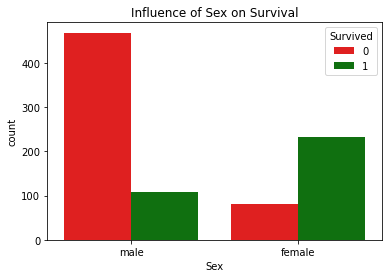

In [17]:
palette = {0: "red", 1: "green"}

plt.title("Influence of Sex on Survival")
sns.countplot(x='Sex', data=train_data, hue = 'Survived', palette=palette);

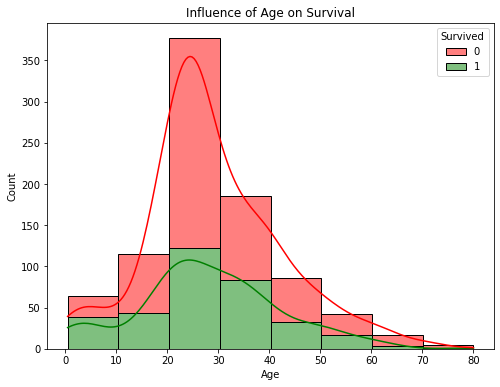

In [18]:
plt.figure(figsize=(8,6))
plt.title("Influence of Age on Survival")
sns.histplot(data=train_data, x='Age', kde = True, bins = 8, hue = 'Survived', multiple = 'stack', palette=palette);

In [19]:
# Setting value types
train_data.Pclass = train_data.Pclass.astype("category")
test_data.Pclass = test_data.Pclass.astype("category")

In [20]:
# Cutting the Age in several categories
train_data.Age = pd.cut(train_data.Age, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80'])
test_data.Age = pd.cut(test_data.Age, bins = [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80'])

# Encoding categorical values
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)

#TODO: try a LabelEncoder, instead of a getdummies

train_data.head()

,Survived,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_0-10,Age_10-20,Age_20-30,Age_30-40,Age_40-50,Age_50-60,Age_60-70,Age_70-80,Embarked_C,Embarked_Q,Embarked_S
0,0,1,0,7.2500,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
1,1,1,0,71.2833,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,1,0,0,7.9250,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1
3,1,1,0,53.1000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,8.0500,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1


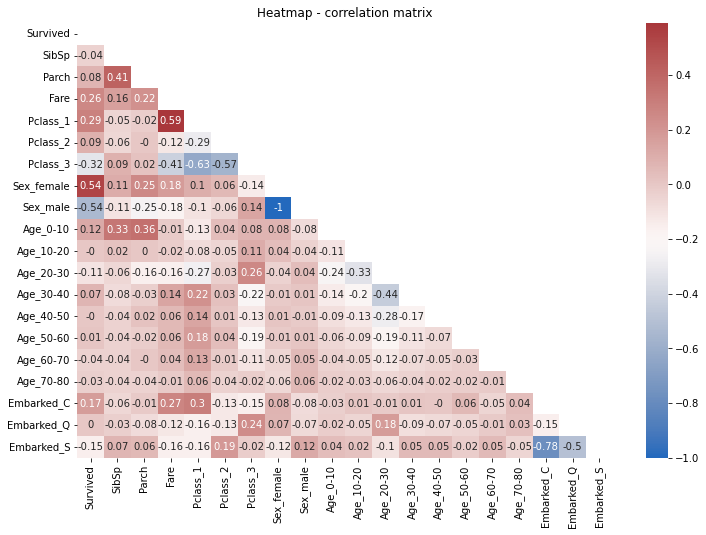

In [21]:
corr = round(train_data.corr(), 2)
matrix = np.triu(np.ones_like(corr))

plt.figure(figsize=(12,8))
plt.title("Heatmap - correlation matrix")
sns.heatmap(data = corr, cmap = 'vlag', annot = True, mask=matrix);

# Splitting and balancing the training dataset

In [22]:
# Looking if our dataset is balanced
train_data.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [23]:
# Splitting test and train
data = train_data.drop(columns=["Survived"])
target = train_data.Survived

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)

In [24]:
# Oversampling, to balance our dataset
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)
print('Classes échantillon SMOTE :', dict(pd.Series(y_train).value_counts()))

Classes échantillon SMOTE : {0: 387, 1: 387}


In [25]:
# Standard scaling
cols = ['SibSp', 'Parch', 'Fare']

sc = preprocessing.StandardScaler()
X_train[cols] = sc.fit_transform(X_train[cols])
X_test[cols] = sc.transform(X_test[cols])

# We also need to scale the values on the validation data (called test in the challenge)
test_data[cols] = sc.transform(test_data[cols])

X_train.head()

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age_0-10,Age_10-20,Age_20-30,Age_30-40,Age_40-50,Age_50-60,Age_60-70,Age_70-80,Embarked_C,Embarked_Q,Embarked_S
0,0.502612,-0.442389,-0.171772,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1
1,0.502612,5.851900,-0.063118,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1
2,-0.455570,-0.442389,-0.538239,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0
3,-0.455570,-0.442389,-0.549920,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1
4,0.502612,-0.442389,-0.565131,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1


In [30]:
#PCA to reduce the number of columns
n_components = 0.95
pca = PCA(n_components = n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA generates {pca.n_components_} features based on the {X_train.shape[1]} we had, to explain {int(n_components*100)}% of our variance.")

PCA generates 11 features based on the 19 we had, to explain 95% of our variance.


# Models

## Logistic Regression

In [57]:
clf_lr = LogisticRegression(max_iter=5000)

param_grid_lr = {'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"], 'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 10000]}

kfold_lr = StratifiedKFold(n_splits=10, shuffle=True)

gcv_lr = GridSearchCV(clf_lr, param_grid_lr, cv=kfold_lr, refit=True, scoring="f1", n_jobs=-1)

gcv_lr.fit(X_train, y_train)

print(f'LogReg best params: {gcv_lr.best_params_}')
print(f'LogReg best score: {round(100*gcv_lr.best_score_,1)}%')

LogReg best params: {'C': 100, 'solver': 'newton-cg'}
LogReg best score: 80.9%


## SVM (Support Vector Machine)

In [58]:
clf_svm = svm.SVC()

param_grid_svm = {'C': [0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100, 1000, 10000],
                    'degree': [1, 2, 3, 4, 5],
                    "gamma": ["scale", "auto"]}

kfold_svm = StratifiedKFold(n_splits=10, shuffle=True)

gcv_svm = GridSearchCV(clf_svm, param_grid_svm, cv=kfold_svm, refit=True, scoring="f1", n_jobs=-1)

gcv_svm.fit(X_train, y_train)

print(f'SVM best params: {gcv_svm.best_params_}')
print(f'SVM best score: {round(100*gcv_svm.best_score_,1)}%')

SVM best params: {'C': 3, 'degree': 1, 'gamma': 'scale'}
SVM best score: 81.4%


## KNN (K nearest neighbors)

In [59]:
clf_knn = neighbors.KNeighborsClassifier()

param_grid_knn = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'metric': ["minkowski"],
                    "leaf_size": [5, 10, 20, 30, 40, 50],
                    "p": [1, 2, 3]}

kfold_knn = StratifiedKFold(n_splits=10, shuffle=True)

gcv_knn = GridSearchCV(clf_knn, param_grid_knn, cv=kfold_knn, refit=True, scoring="f1", n_jobs=-1)

gcv_knn.fit(X_train, y_train)

print(f'KNN best params: {gcv_knn.best_params_}')
print(f'KNN best score: {round(100*gcv_knn.best_score_,1)}%')

KNN best params: {'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 4, 'p': 2}
KNN best score: 80.0%


## Decision Tree

In [61]:
clf_dt = DecisionTreeClassifier()

param_grid_dt = {'max_depth': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'criterion': ["gini", "entropy"],
                    "min_samples_leaf": [1, 2, 3, 4, 5]}

kfold_dt = StratifiedKFold(n_splits=10, shuffle=True)

gcv_dt = GridSearchCV(clf_dt, param_grid_dt, cv=kfold_dt, refit=True, scoring="f1", n_jobs=-1)

gcv_dt.fit(X_train, y_train)

print(f'Decision tree best params: {gcv_dt.best_params_}')
print(f'Decision tree best score: {round(100*gcv_dt.best_score_,1)}%')

Decision tree best params: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}
Decision tree best score: 81.9%


## XGBoost

In [300]:
#Really necessary?

#xgb_train = xgb.DMatrix(X_train, y_train)
#xgb_test = xgb.DMatrix(X_test, y_test)

In [62]:
param_grid_xgb = {
        'min_child_weight': [0.5, 1, 2],
        'gamma': [0, 0.5, 1],
        'subsample': [0.1, 0.5, 1],
        'colsample_bytree': [0.1, 0.5, 1],
        'max_depth': [4, 5, 6],
        'learning_rate': [0.01, 0.1, 0.2, 0.3]
        }

kfold = StratifiedKFold(n_splits=10, shuffle=True)

xgb1 = xgb.XGBClassifier(use_label_encoder=False)

xgb_cv = GridSearchCV(xgb1, param_grid_xgb, n_jobs=-1, cv=kfold, scoring="f1")

xgb_cv.fit(X_train, y_train, eval_metric='logloss')

print(f'XGB best params: {xgb_cv.best_params_}')
print(f'XGB best score: {round(100*xgb_cv.best_score_,1)}%')

Best params: {'colsample_bytree': 1, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 1}
Best score: 84.5%


In [63]:
# Let's train our model with the best params
xgb1 = xgb.XGBClassifier(use_label_encoder=False, **xgb_cv.best_params_)
xgb1.fit(X_train, y_train, eval_metric='logloss')
print(f'XGB score on test data: {round(100*xgb1.score(X_test, y_test),1)}%')

XGB score on test data: 84.7%


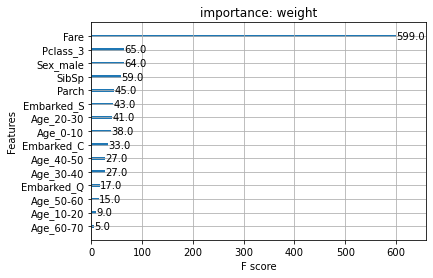

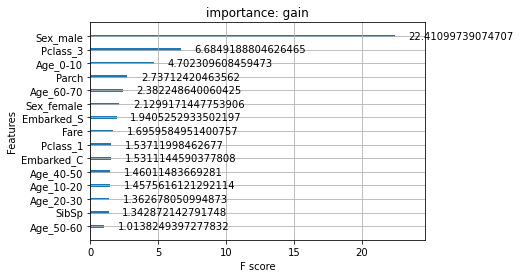

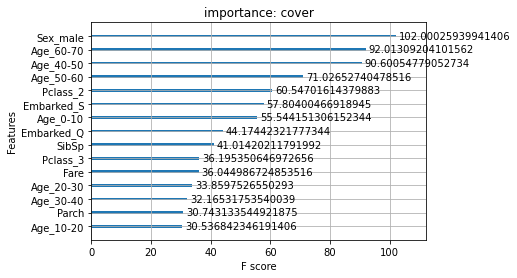

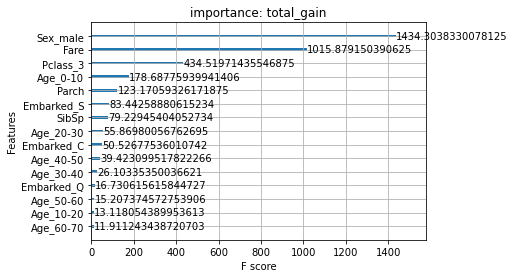

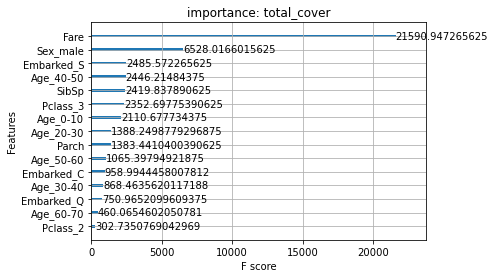

In [64]:
types= ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

for f in types:
    xgb.plot_importance(xgb1 ,max_num_features=15, importance_type=f, title='importance: '+f);

In [65]:
# Stocke dans preds les probabilités obtenues avec xgb2 sur test
preds = xgb1.predict(test_data)

In [66]:
gender_data['Survived'] = preds

gender_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [67]:
gender_data.to_csv('submission/xgb_submission.csv', index=False)